# 0. Extra Config as my pc has multiple JVMs 

In [1]:
!/usr/libexec/java_home -V

Matching Java Virtual Machines (8):
    23 (arm64) "Eclipse Adoptium" - "OpenJDK 23" /Library/Java/JavaVirtualMachines/temurin-23.jdk/Contents/Home
    19.0.2 (arm64) "Amazon.com Inc." - "Amazon Corretto 19" /Users/him/Library/Java/JavaVirtualMachines/corretto-19.0.2/Contents/Home
    17.0.8 (arm64) "Oracle Corporation" - "Java SE 17.0.8" /Library/Java/JavaVirtualMachines/jdk-17.jdk/Contents/Home
    11.0.23 (arm64) "Amazon.com Inc." - "Amazon Corretto 11" /Users/him/Library/Java/JavaVirtualMachines/corretto-11.0.23/Contents/Home
    11.0.22 (arm64) "Eclipse Adoptium" - "OpenJDK 11.0.22" /Library/Java/JavaVirtualMachines/temurin-11.jdk/Contents/Home
    1.8.431.10 (x86_64) "Oracle Corporation" - "Java" /Library/Internet Plug-Ins/JavaAppletPlugin.plugin/Contents/Home
    1.8.0_412 (arm64) "Amazon" - "Amazon Corretto 8" /Users/him/Library/Java/JavaVirtualMachines/corretto-1.8.0_412/Contents/Home
    1.8.0_412 (x86_64) "Amazon" - "Amazon Corretto 8" /Users/him/Library/Java/JavaVirtualMach

In [2]:
import os

In [3]:
java_path = "/Library/Java/JavaVirtualMachines/jdk-17.jdk/Contents/Home"
java_home = os.environ.get('JAVA_HOME', None)

print("Existing Java Home: ",java_home)

if (not java_home) or (java_path not in java_home):
    os.environ['JAVA_HOME'] = java_path

print("Updated Java Home: ",os.environ.get('JAVA_HOME', None))

Existing Java Home:  None
Updated Java Home:  /Library/Java/JavaVirtualMachines/jdk-17.jdk/Contents/Home


In [4]:
# print java version

os.system('java -version')

java version "17.0.8" 2023-07-18 LTS
Java(TM) SE Runtime Environment (build 17.0.8+9-LTS-211)
Java HotSpot(TM) 64-Bit Server VM (build 17.0.8+9-LTS-211, mixed mode, sharing)


0

# 1. Load data

In [5]:
import pandas as pd

In [6]:
train_df = pd.read_csv('../data/train.csv')

# 2. Prepocessing

In [7]:
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession

In [8]:
train_df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
train_df['Sex'] = train_df['Sex'].apply(lambda x: 1 if x == 'male' else 0)
train_df['Age'] = train_df['Age'].fillna(train_df['Age'].mean())
train_df['Embarked'] = train_df['Embarked'].apply(lambda x: 0 if x == 'S' else 1)

In [9]:
spark = SparkSession\
        .builder\
        .appName("ensemble")\
        .getOrCreate()


24/11/30 00:07:07 WARN Utils: Your hostname, Yuen-Man-Hims-MacBook-Pro-2.local resolves to a loopback address: 127.0.0.1; using 192.168.0.31 instead (on interface en0)
24/11/30 00:07:07 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/30 00:07:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [10]:
data = spark.createDataFrame(train_df)
train, valid = data.randomSplit([0.5, 0.5], seed=12345)

assembler = VectorAssembler(
    inputCols = train_df.columns[1:].to_list(),
    outputCol = "features")
train = assembler.transform(train)
valid = assembler.transform(valid)
y_true = valid.select('Survived').toPandas()

# 3. Model

In [11]:
from sklearn.metrics import f1_score

## 3.1 Naive-bayes

In [12]:
from pyspark.ml.classification import NaiveBayes

In [13]:
# create the trainer and set its parameters
nb = NaiveBayes(
    smoothing=1.0, 
    modelType="complement", 
    labelCol="Survived"
    )

# train the model
nbModel = nb.fit(train)

# select example rows to display.
nbResult = nbModel.transform(valid)

24/11/30 00:07:14 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/11/30 00:07:14 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


In [14]:
nbResult.show()

+--------+------+---+-----------------+-----+-----+-------+--------+--------------------+--------------------+--------------------+----------+
|Survived|Pclass|Sex|              Age|SibSp|Parch|   Fare|Embarked|            features|       rawPrediction|         probability|prediction|
+--------+------+---+-----------------+-----+-----+-------+--------+--------------------+--------------------+--------------------+----------+
|       0|     1|  1|29.69911764705882|    0|    0|27.7208|       1|[1.0,1.0,29.69911...|[-0.1635464161570...|[0.84912708487071...|       0.0|
|       0|     1|  1|             40.0|    0|    0|27.7208|       1|[1.0,1.0,40.0,0.0...|[-0.0030416195769...|[0.99696300146153...|       0.0|
|       0|     1|  1|             42.0|    1|    0|   52.0|       0|[1.0,1.0,42.0,1.0...|[-3.1727005753096...|[0.04189031705461...|       1.0|
|       0|     2|  0|             27.0|    1|    0|   21.0|       0|[2.0,0.0,27.0,1.0...|[-0.0297801511297...|[0.97065890835693...|       0.0|

In [15]:
nb_y_pred = nbResult.select('prediction').toPandas().values
nb_f1 = f1_score(y_true, nb_y_pred)

## 3.2 Linear Support Vector Machine (LinearSVM)

In [16]:
from pyspark.ml.classification import LinearSVC

In [17]:
lsvc = LinearSVC(maxIter=10, regParam=0.1, labelCol="Survived", featuresCol="features")

# Fit the model
lsvcModel = lsvc.fit(train)

lsvcResult = lsvcModel.transform(valid)

In [18]:
lsvcResult.show()

+--------+------+---+-----------------+-----+-----+-------+--------+--------------------+--------------------+----------+
|Survived|Pclass|Sex|              Age|SibSp|Parch|   Fare|Embarked|            features|       rawPrediction|prediction|
+--------+------+---+-----------------+-----+-----+-------+--------+--------------------+--------------------+----------+
|       0|     1|  1|29.69911764705882|    0|    0|27.7208|       1|[1.0,1.0,29.69911...|[0.72062011382097...|       0.0|
|       0|     1|  1|             40.0|    0|    0|27.7208|       1|[1.0,1.0,40.0,0.0...|[0.77474999872314...|       0.0|
|       0|     1|  1|             42.0|    1|    0|   52.0|       0|[1.0,1.0,42.0,1.0...|[0.99269764918982...|       0.0|
|       0|     2|  0|             27.0|    1|    0|   21.0|       0|[2.0,0.0,27.0,1.0...|[-0.9167048385109...|       1.0|
|       0|     2|  1|             32.0|    0|    0|   10.5|       0|[2.0,1.0,32.0,0.0...|[0.93969021801855...|       0.0|
|       0|     2|  1|   

In [19]:
lsvc_y_pred = lsvcResult.select('prediction').toPandas().values
lsvc_f1 = f1_score(y_true, lsvc_y_pred)

## 3.3 Multilayer Perceptron (MLP)

In [20]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

In [21]:
trainer = MultilayerPerceptronClassifier(
    labelCol="Survived",
    featuresCol="features",
    maxIter=1500, 
    layers=[7, 32, 64, 16, 2], 
    blockSize=64, 
    seed=1234
    )

# train the model
mlpModel = trainer.fit(train)

# compute accuracy on the test set
mlpResult = mlpModel.transform(valid)

In [22]:
mlpResult.show()

+--------+------+---+-----------------+-----+-----+-------+--------+--------------------+--------------------+--------------------+----------+
|Survived|Pclass|Sex|              Age|SibSp|Parch|   Fare|Embarked|            features|       rawPrediction|         probability|prediction|
+--------+------+---+-----------------+-----+-----+-------+--------+--------------------+--------------------+--------------------+----------+
|       0|     1|  1|29.69911764705882|    0|    0|27.7208|       1|[1.0,1.0,29.69911...|[-2.2066734482881...|[0.08339654463480...|       1.0|
|       0|     1|  1|             40.0|    0|    0|27.7208|       1|[1.0,1.0,40.0,0.0...|[-0.1361553795740...|[0.84127051959492...|       0.0|
|       0|     1|  1|             42.0|    1|    0|   52.0|       0|[1.0,1.0,42.0,1.0...|[-1.4286869040623...|[0.29469196443589...|       1.0|
|       0|     2|  0|             27.0|    1|    0|   21.0|       0|[2.0,0.0,27.0,1.0...|[0.29793186825445...|[0.92546211645898...|       0.0|

In [23]:
mlp_y_pred = mlpResult.select('prediction').toPandas().values
mlp_f1 = f1_score(y_true, mlp_y_pred)

# 4. Ensemble of 3 models (Naive-bayes, LinearSVM, MLP)

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score

accuracy:  0.8202247191011236
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       276
           1       0.80      0.70      0.75       169

    accuracy                           0.82       445
   macro avg       0.81      0.80      0.80       445
weighted avg       0.82      0.82      0.82       445



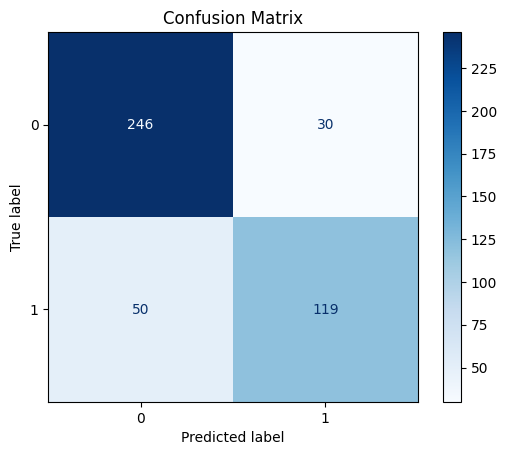

In [25]:
f1_total = nb_f1 + lsvc_f1 + mlp_f1
y_pred = np.round((nb_y_pred * nb_f1 + lsvc_y_pred * lsvc_f1 + mlp_y_pred * mlp_f1)/f1_total)

# Create accuracy score
print("accuracy: ", accuracy_score(y_true, y_pred))

# Create classification report
print(classification_report(y_true, y_pred))

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# 5. Produce the submission file

In [26]:
test_df = pd.read_csv('../data/test.csv')

test_df.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
test_df['Sex'] = test_df['Sex'].apply(lambda x: 1 if x == 'male' else 0)
test_df['Age'] = test_df['Age'].fillna(test_df['Age'].mean())
test_df['Fare'] = test_df['Fare'].fillna(test_df['Fare'].mean())
test_df['Embarked'] = test_df['Embarked'].apply(lambda x: 0 if x == 'S' else 1)

In [27]:
# show non null values summary
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Sex          418 non-null    int64  
 3   Age          418 non-null    float64
 4   SibSp        418 non-null    int64  
 5   Parch        418 non-null    int64  
 6   Fare         418 non-null    float64
 7   Embarked     418 non-null    int64  
dtypes: float64(2), int64(6)
memory usage: 26.3 KB
None


In [28]:
test = assembler.transform(spark.createDataFrame(test_df))

In [29]:
nb_pred = nbModel.transform(test).select('prediction').toPandas().values
lsvc_pred = lsvcModel.transform(test).select('prediction').toPandas().values
mlp_pred = mlpModel.transform(test).select('prediction').toPandas().values

y_pred = np.round((nb_pred * nb_f1 + lsvc_pred * lsvc_f1 + mlp_pred * mlp_f1)/f1_total)

In [ ]:
df = pd.DataFrame({'PassengerId': test.toPandas()['PassengerId'], 'Survived': y_pred.flatten().astype(int)})
df.to_csv('result/submission.csv', index=False)